# Traffic Sign Classifier using a Vision Transformer
- Dataset used: https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed
- Code largely adapted from Vision Transformer Keras example: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [48]:
# Required libraries

import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


## Prepare the Data

In [49]:
# Load the data from the pickle file (reading in binary mode)

with open ('archive/data0.pickle', 'rb') as f:
    data = pickle.load(f,encoding='latin1') # latin1 is the dictionary type

# Transpose structure of the datasets so that the channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Confirm the sizes of the loaded data
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

x_test: (12630, 32, 32, 3)
y_validation: (4410,)
x_validation: (4410, 3, 32, 32)
labels: 43
x_train: (86989, 32, 32, 3)
y_test: (12630,)
y_train: (86989,)


## Visualise the Data

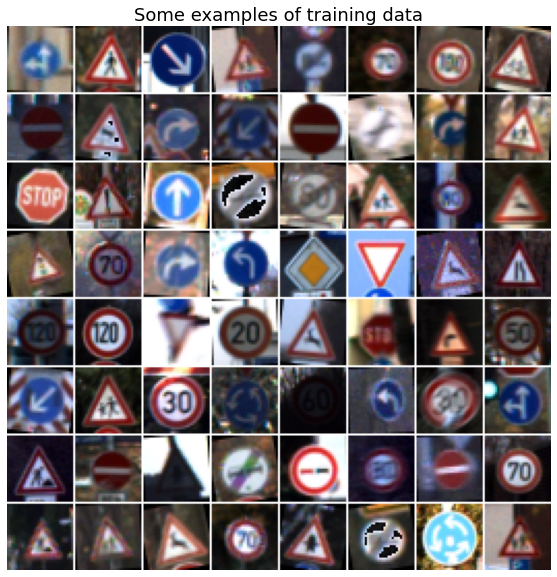

In [50]:
# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:64, :, :, :]

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10) # to show the images a bit larger, so they can be seen
plt.title('Training Data Examples', fontsize=18)

# Showing the plot
plt.show()


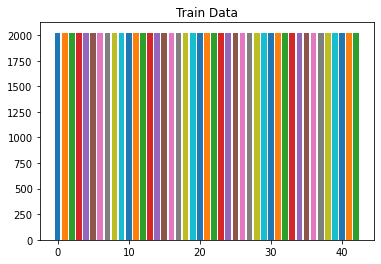

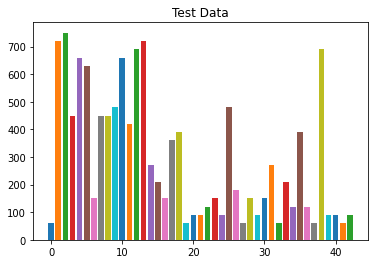

In [51]:
def class_distrib(dataset, title):
    unique, counts = np.unique(dataset, return_counts=True)
    test_freq = np.asarray((unique, counts)).T

    for entry in test_freq:
        plt.bar(entry[0], entry[1])
    plt.title(title)
    plt.show()

class_distrib(data['y_train'], "Train Data")
class_distrib(data['y_test'], "Test Data")

# Note how the training data seems to have a perfect split


## Build the Vision Transformer
### Configure Hyperparameters

In [52]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20 # Start small for testing purposes
image_size = 32 
patch_size = 6  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Multilayer Perceptron (MLP)

In [53]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patch creation as a layer
One of the main aspects of the vision transformer is how it splits its input images into sequences of patches, so this custom layer enables us to do that

In [54]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Implement the patch encoding layer
- This layer ensures the patches are processed as a sequence through linearly transforming the patches by projecting them into a vector
- Also embeds a learnable position to the projected vector

In [55]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Build the Vision Transformer Model
- Uses multiple Transformer blocks which apply a Multi-Head Attention to the sequence of patches
- These blocks output a tensor with a batch size, number of patches and projection dimensions, with is processed via SoftMax to output the probabilities
- Output of final block is reshaped with Flatten()

In [56]:
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size, 3)) # Three colour channels
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(43)(features) # 43 classes in dataset
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Train the Model

In [57]:
def train_model(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=data['x_train'],
        y=data['y_train'],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
    )

    _, accuracy, top_5_accuracy = model.evaluate(data['x_test'], data['y_test'])
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [58]:
vit_classifier = create_vit_classifier()
history = train_model(vit_classifier)

Epoch 1/20
272/272 [==============================] - 253s 911ms/step - loss: 1.3650 - accuracy: 0.6168 - top-5-accuracy: 0.8236 - val_loss: 0.1829 - val_accuracy: 0.9534 - val_top-5-accuracy: 0.9903
Epoch 2/20
272/272 [==============================] - 247s 908ms/step - loss: 0.3413 - accuracy: 0.8950 - top-5-accuracy: 0.9866 - val_loss: 0.0967 - val_accuracy: 0.9714 - val_top-5-accuracy: 0.9954
Epoch 3/20
272/272 [==============================] - 247s 908ms/step - loss: 0.2204 - accuracy: 0.9296 - top-5-accuracy: 0.9936 - val_loss: 0.0628 - val_accuracy: 0.9828 - val_top-5-accuracy: 0.9966
Epoch 4/20
272/272 [==============================] - 250s 918ms/step - loss: 0.1690 - accuracy: 0.9464 - top-5-accuracy: 0.9958 - val_loss: 0.0560 - val_accuracy: 0.9838 - val_top-5-accuracy: 0.9978
Epoch 5/20
272/272 [==============================] - 243s 892ms/step - loss: 0.1431 - accuracy: 0.9549 - top-5-accuracy: 0.9969 - val_loss: 0.0395 - val_accuracy: 0.9895 - val_top-5-accuracy: 0.9984


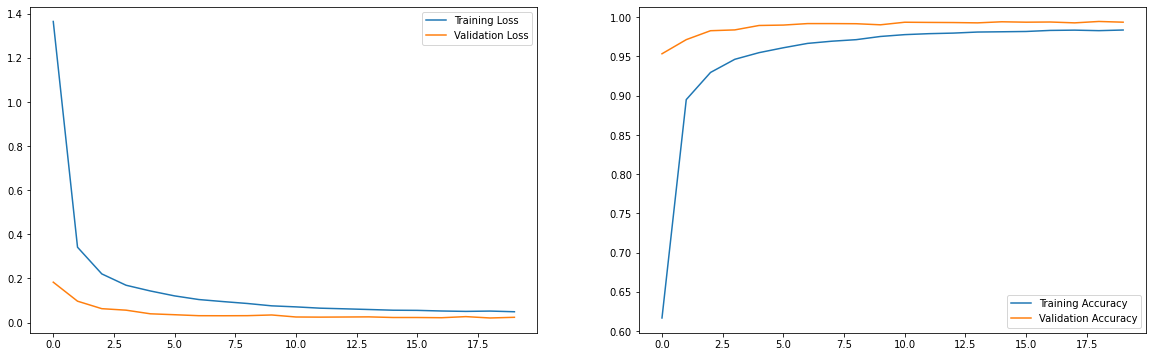

In [59]:
# Visualise the model's training

def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend(); 

plot_training(history)

### Substantially accurate results, but the graphs of the loss and accuracy evidence the possibility of overfitting of the dataset